In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis = 1)

In [4]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop("hour", axis = 1)

In [5]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
for label in df.columns [1:] :
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike count at noon")
  plt.xlabel(label)
  plt.show()

In [7]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [8]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train/Valid/Test Dataset

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [10]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((x, y))

  return data, x, y

#Single param Linear Regression

In [11]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels = ["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels = ["temp"])

In [12]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [13]:
temp_reg.score(x_test_temp, y_test_temp)

0.1996719236568879

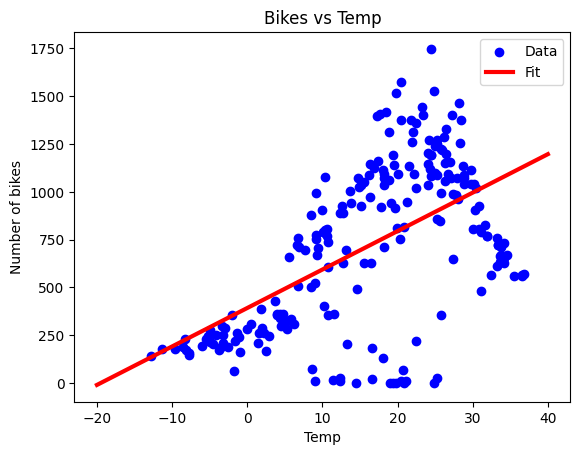

In [14]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#All param Linear Regression

In [16]:
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels = df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [17]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [18]:
all_reg.score(x_test_all, y_test_all)

0.34952171411428345

#Regression with Neural Net

#1 node 1 param

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)

  plt.show()

In [20]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [21]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [22]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), loss = "mean_squared_error")

In [23]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (x_val_temp, y_val_temp)
)

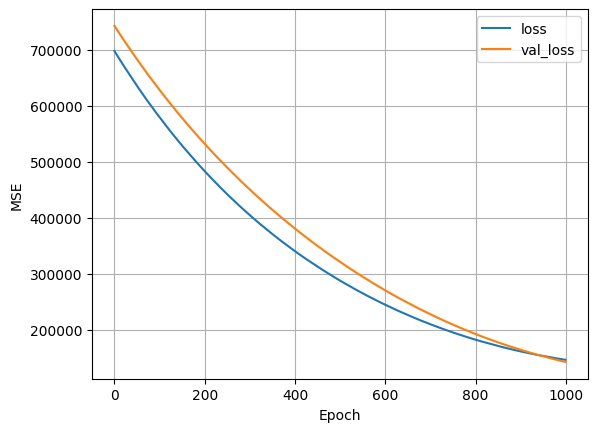

In [24]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


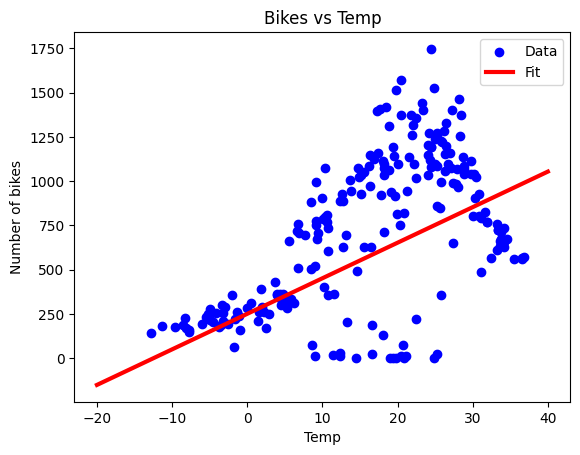

In [25]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Neural Net Multiple node 1 param

In [36]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [37]:
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = "mean_squared_error")

In [38]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_val_temp, y_val_temp),
    verbose = 0, epochs = 100
)

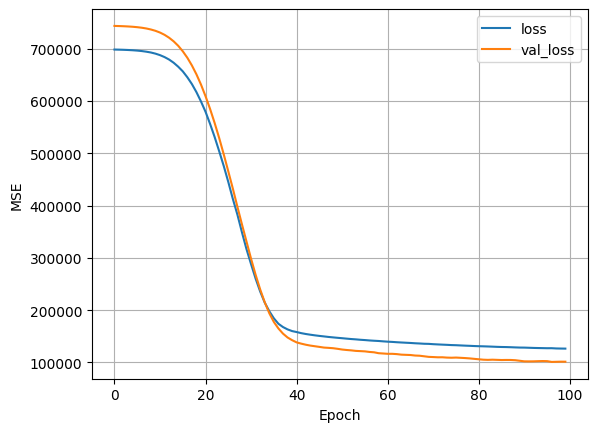

In [39]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


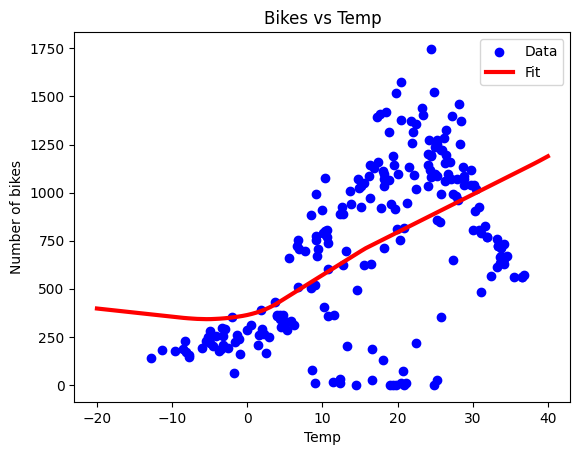

In [40]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#All param

In [54]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [55]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [56]:
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = "mean_squared_error")

In [57]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_val_all, y_val_all),
    verbose = 0, epochs = 100
)

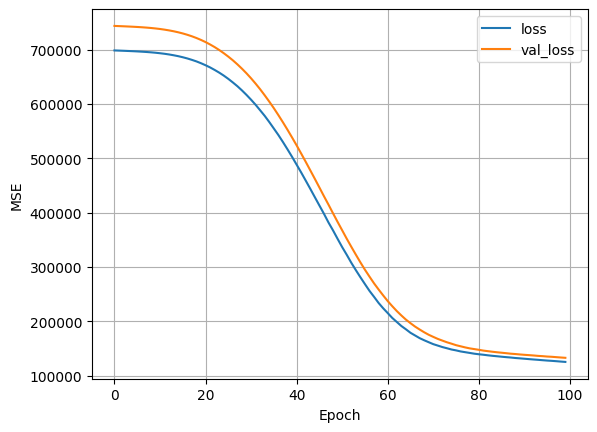

In [58]:
plot_loss(history)

In [59]:
#calculate Mean Squared error for Linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 3ms/step


In [60]:
def mse(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [61]:
mse(y_pred_lr, y_test_all)

114866.15908617941

In [62]:
mse(y_pred_nn, y_test_all)

137639.5795227671

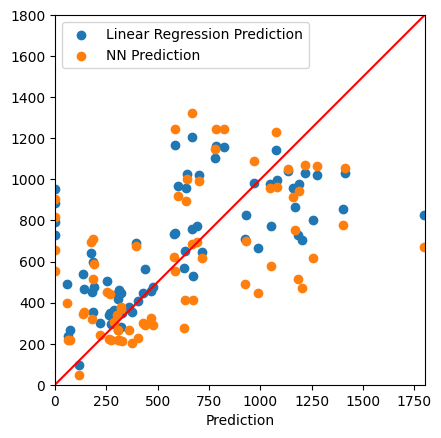

In [64]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label = "Linear Regression Prediction")
plt.scatter(y_test_all, y_pred_nn, label = "NN Prediction")
plt.xlabel("True Values")
plt.xlabel("Prediction")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")